In [2]:
# Useful Imports
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
# Parameters
S0: float = 100
K: float = 100
T: float = 1
r: float = 0.05
sigma: float = 0.2
d: int = 12
N: int = 100000

1. Tracer en fonction de $S_0$ sur un même graphe le prix exact du call européen et le prix
 Monte Carlo de l’option asiatique de mêmes strike et maturité à $d$ dates. Commenter.

On redéfinit la fonction premettant le calcul du prix d'un call européen dans le cadre du modèle de Black & Scholes via sa formule explicite:

In [4]:
def call_price_black_scholes(K: float, T: float, S0: float, r: float, sigma: float) -> float:
    """
    Works out the price at time 0 of a European call option on the underlying S
    with maturity T and strike K

    **INPUT:**
    - K: strike of the option
    - T: maturity of the option
    - S0: price of the underlying asset S at time 0
    - r: risk-free rate
    - sigma: volatility

    **OUTPUTS:**
    - C0: price of the call option at time 0
    """
    d1 = 1 / (sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + sigma**2 / 2) * T)
    d2 = d1 - sigma * np.sqrt(T)

    # Computing the call price at time 0
    c0 = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return c0

Pour la simulation de Monte Carlo de l'option asiatique, en reprenant la formule pour le pricing d'une option dépendante de la trajectoire:

$$
\forall i \in [\![1, d]\!], S_{t_i} = S_{t_{i-1}}e^{(r - \frac{\sigma^2}{2}) (t_i - t_{i-1}) + \sigma (B^{\mathbb{Q}}_{t_i} - B^{\mathbb{Q}}_{t_{i-1}})} = S_{t_{i-1}}e^{(r - \frac{\sigma^2}{2}) (t_i - t_{i-1}) + \sigma \sqrt{t_i - t_{i-1}}X_i} 
$$

où $\forall i \in [\![1, d]\!], X_i \hookrightarrow \mathcal{N}(0, 1)$ et sont mutuellements indépendantes (car le mouvement brownien est un processus à accroissements indépendants).

On simplifie le problème en prenant des intervalles de temps réguliers. Ainsi:

$$
t_i - t_{i-1} = \frac{T}{d}
$$

On peut donc implémenter les formules permettant le calcul approché du prix du call arithmétique asiatique:

In [5]:
def standard_error(Xs: np.ndarray) -> np.ndarray:
    """
    Computes the Bessel-corrected standard error.

    **INPUT:**
        - Xs: Samples on which we compute the ste.

    **OUTPUT:**
        - std_err: Standard error.
    """
    std_err = np.sqrt(np.var(Xs, ddof=1) / len(Xs))
    return std_err


def monte_carlo_discrete_path(
    N: int, d: int, T: float, S0: float, r: float, sigma: float
) -> np.ndarray:
    """
    Builds N Monte-Carlo discrete paths of each n values (S0, S1 ... Sn) for the underlying asset price.

    **INPUT:**
        - N: Sample size.
        - d: Time-series length.
        - T: Time to maturity (in years).
        - S0: Current price of the underlying asset.
        - r: Risk-free interest rate.
        - sigma: Volatility of the underlying asset.

    **OUTPUT:**
        - np.ndarray(N,d): The underlying asset price array.
    """
    random_factors = np.exp(
        (r - (sigma**2) / 2) * T / d
        + sigma * np.sqrt(T / d) * np.random.normal(size=(N, d))
    )
    return S0 * np.cumprod(np.insert(random_factors, 0, 1, axis=1), axis=1)


def MC_est_asian_arith_option(
    K: float, T: float, S0: float, r: float, sigma: float, n: int, alpha: float = 0.05
) -> tuple[float, np.ndarray]:
    """
    Generates N Monte-Carlo prices for a discrete arithmetic Asian option.

    **INPUT:**
    - K: Strike price of the option
    - T: Time to maturity (in years)
    - S0: Current price of the underlying asset
    - r: Risk-free rate
    - sigma: Volatility of the underlying asset
    - alpha: Level of the confidence interval

    **OUTPUT:**
    - The N Monte-Carlo prices of the European call option
    - The confidence interval.
    """
    payoffs = np.maximum(
        monte_carlo_discrete_path(N=N, d=n, T=T, S0=S0, r=r, sigma=sigma)[:, 1:].mean(
            axis=1
        )
        - K,
        0,
    )
    Cn = np.mean(np.exp(-r * T) * payoffs)
    return Cn, Cn + np.array(norm.interval(1 - alpha)) * np.exp(
        -r * T
    ) * standard_error(payoffs)

On trace les résultats call européen vs call asiatique arithmétique:

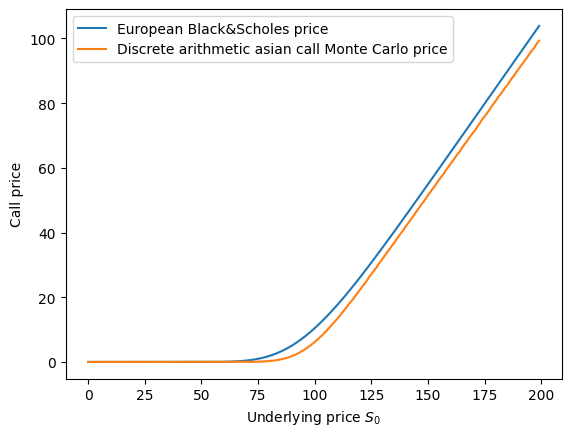

In [6]:
S = np.arange(0.01, 200, 1)
bs_price = [call_price_black_scholes(K, T, s, r, sigma) for s in S]
MC_asian_price = [MC_est_asian_arith_option(K, T, s, r, sigma, d)[0] for s in S]
plt.plot(S, bs_price, label="European Black&Scholes price")
plt.plot(S, MC_asian_price, label="Discrete arithmetic asian call Monte Carlo price" )
plt.xlabel("Underlying price $S_0$")
plt.ylabel("Call price")
plt.legend()
plt.show()

On peut remarquer que le prix du call asiatique est toujours plus bas que celui du call européen. Ceci peut s'expliquer par le fait que les options asiatiques, par la présence de la moyenne, possèdent une volatilité plus faible que les options européenes, ce qui fait diminuer leur prix.

De plus, si on compare les courbes on remarque que lorsque le sous-jacent tend vers 0. On retrouve bien une asymptote en $C=0$, et lorsque $S_0\rightarrow \infty$, on a une pente égale à celle du prix de Black-Scholes. 

2. Tracer le prix Monte Carlo de l’option asiatique et l’intervalle de confiance associé en fonction du nombre de dates d’observations $d$. Commenter.

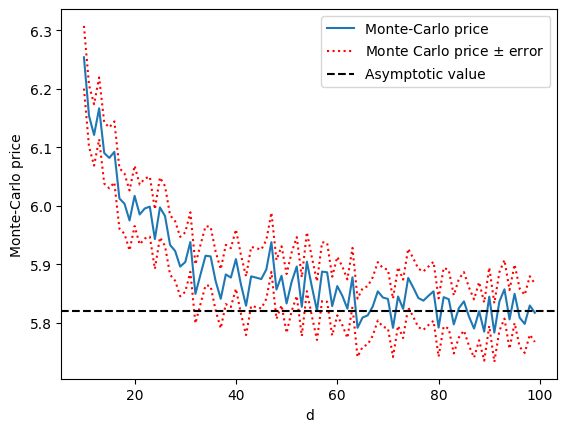

In [22]:
Cns, Cns_up, Cns_down = [], [], []
d_range = [i for i in range(10, 100)]
for n in d_range:
    Cn, error_Cn = MC_est_asian_arith_option(K, T, S0, r, sigma, n)
    Cns.append(Cn)
    Cns_up.append(error_Cn[1])
    Cns_down.append(error_Cn[0])
plt.plot(d_range, Cns, label="Monte-Carlo price")
plt.plot(d_range, Cns_up, linestyle=":", color="red", label="Monte Carlo price $\pm$ error")
plt.plot(d_range, Cns_down, linestyle=":", color="red")
plt.xlabel("d")
plt.ylabel("Monte-Carlo price")
plt.axhline(y=5.82, color='black', linestyle='--', label="Asymptotic value")
plt.legend()
plt.show()

Le prix fluctue beaucoup pour des petites valeurs de $d$. De plus, la variation du paramêtre $d$ pour $d \ge 20$ n'a aucune influence visible sur la réduction de l'incertitude au niveau de l'estimation du prix, ce qui n'est pas nécessairement surprenant car il s'agit d'un paramêtre du modèle qui ne permet pas de rendre la simulation plus précise ( pas comme la variation du paramêtre $N$, ce qui avait été fait lors du TPI). Le prix semble converger vers une valeur asymptotique lorsque $d>>1$.

3. Calculer le prix de Monte-Carlo de l'option asiatique avec la variable de contrôle $Z = S_T$ (que vaut $\mathbb{E}(Z)$?). Vérifier que le prix de Monte Carlo avec la variable de contrôle est correct. Quel est le facteur de réduction de variance obtenu? Estimer par simulation le facteur de réduction théorique. Commenter.

Sous la probabilité risque neutre $\mathbb{Q}$, $S_t = S_0 e^{(r - \frac{\sigma^2}{2})t + \sigma B_{t}^{\mathbb{Q}}}$. Or $(S_0e^{- \frac{\sigma^2}{2}t + \sigma B_{t}^{\mathbb{Q}}})$ est une martingale usuelle car $(B_t^{\mathbb{Q}})$ est un mouvement brownien donc une martingale. Ainsi, dans le cas où $Z = S_T$:

$$
\mathbb{E}(Z) = \mathbb{E}(S_T) = e^{rT}\mathbb{E}(S_0e^{- \frac{\sigma^2}{2}t + \sigma B_{t}^{\mathbb{Q}}}) = e^{rT} S_0
$$

In [8]:
def c_opti_z1(sim_x: np.ndarray, r: float, T: float, K: float) -> tuple[float, np.ndarray, np.ndarray]:
    """
    Calculates the optimal c parameter for maximum variance reduction for
    the control variable when Z=S_T

    **INPUT:**
    - sim_x: Monte-Carlo simulations of the underlying asset
    - r: Risk-free rate
    - T: Maturity of the option
    - K: Strike price of the option

    **OUTPUT:**
    - Optimal c value parameter
    - h_vect: Vector containing the different simulated values for the Asian option prices
    - z1_vect: Control variable simulated values
    """
    # Working out the numerator
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    h_mean = h_vect.mean()
    z1_vect = sim_x[:, -1]
    z1_mean = z1_vect.mean()
    numerator = np.sum((h_vect - h_mean) * (z1_vect - z1_mean))
    # Working out the denominator
    denominator = np.sum(np.square(z1_vect - z1_mean))
    return (- (numerator/denominator), h_vect, z1_vect)

sim_x = monte_carlo_discrete_path(N, d, T, S0, r, sigma)

# Calculating the option price with the control variable
esp_z1 = np.exp(r * T)* S0
c_star_z1, h_vect, z1_vect = c_opti_z1(sim_x, r, T, K)
Cc_z1 = np.mean(h_vect + c_star_z1 * (z1_vect - esp_z1))
print(f"Price of the option with the first control variable: {Cc_z1}")


Price of the option with the first control variable: 6.157437709536377


Le prix obtenu correspond bien à celui obtenu lors de la question précédente. Déterminons le facteur de réduction de variance, exprimé par:

$$
Red_{var} = \frac{\mathbb{V}ar(C_X)}{\mathbb{V}ar(C_{c^*})} =\frac{1}{1 - \rho^2_{(h(X), Z)}}
$$

On peut approcher la corrélation avec les variables simulées

In [9]:
# Reduction coefficient calculation
fact_red_z1 = 1 / (1 - np.corrcoef(z1_vect, h_vect)[0, 1]**2)
print(f"Reduction factor is: {fact_red_z1} for d=12")

Reduction factor is: 3.054059058429437 for d=12


On peut tester pour une plage de valeurs de $d$:

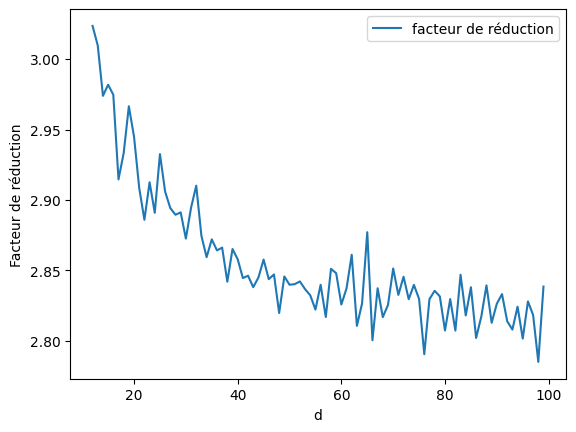

In [10]:
d_range = [i for i in range(12, 100)]
fact_red_list = []
for n in d_range:
    sim_x = monte_carlo_discrete_path(N, n, T, S0, r, sigma)
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    z1_vect = sim_x[:, -1]
    fact_red = 1 / (1 - np.corrcoef(h_vect, z1_vect)[0, 1] ** 2)
    fact_red_list.append(fact_red)

plt.plot(d_range, fact_red_list, label="facteur de réduction")
plt.xlabel("d")
plt.ylabel("Facteur de réduction")
plt.legend()
plt.show()

Nous voyons que grâce à cette méthode, la variance est réduite par 2.85 pour un pas de temps de 45 par example. Ceci permet de réduire l'intervalle de confiance, et ce même pour les valeurs de $d$ plus élevées. Cependant, celui-ci semble diminuer avec la croissance de $d$, puis se stabiliser à partir de $d=60$.

4. Même question avec $Z = \frac{1}{d} \sum_{i=1}^d S_{t_i}$, puis $Z = e^{-rt}(S_T - K)_{+}$

On traite d'abord le cas où:

$$
Z = \frac{1}{d} \sum_{i=1}^{d}S_{t_i}
$$

On a: 

$$
\mathbb{E}(Z) = \mathbb{E}\left(\frac{1}{d} \sum_{i=1}^{d} S_{t_i}\right) = \frac{1}{d} \sum_{i=1}^{d} \mathbb{E}(S_{t_i})
$$

Or:

$$
\forall i \in [\![1, d]\!], \mathbb{E}(S_{t_i}) = e^{r \frac{iT}{d}}\mathbb{E}(S_0e^{\sigma B^{\mathbb{Q}}_{t_i} - \frac{\sigma^2}{2}t_i}) = e^{r \frac{iT}{d}}S_0
$$

par propriété de martingale. Ainsi:

$$
\mathbb{E}(Z) = \frac{S_0}{d}\sum_{i=1}^{d} (e^{\frac{rT}{d}})^i = \frac{S_0}{d}  e^{\frac{rT}{d}} \frac{1 - e^{rT}}{1 - e^{\frac{rT}{d}}}
$$

Calculons le $c^*$ associé et déduisons-en le facteur de réduction.

In [45]:
def c_opti_z2(sim_x: np.ndarray, r: float, T: float, K: float) -> tuple[float, np.ndarray, np.ndarray]:
    """
    Calculates the optimal c parameter for maximum variance reduction for
    the control variable when Z=avg(S_ti)

    **INPUT:**
    - sim_x: Monte-Carlo simulations of the underlying asset
    - r: Risk-free rate
    - T: Maturity of the option
    - K: Strike price of the option

    **OUTPUT:**
    - Optimal c value parameter
    - h_vect: Vector containing the different simulated values for the Asian option prices
    - z2_vect: Control variable simulated values
    """
    # Working out the numerator
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    h_mean = h_vect.mean()
    z2_vect = sim_x[:, 1:].mean(axis=1)
    z2_mean = z2_vect.mean()
    numerator = np.sum((h_vect - h_mean) * (z2_vect - z2_mean))

    # Working out the denominator
    denominator = np.sum(np.square(z2_vect - z2_mean))
    return (- (numerator/denominator), h_vect, z2_vect)


sim_x = monte_carlo_discrete_path(N, d, T, S0, r, sigma)
# Calculating the option price with the second control variable
esp_z2 = (S0 / d) * np.exp((r * T) / d) * ((1 - np.exp(r * T)) / (1 - np.exp((r * T)/d)))
c_star_z2, h_vect, z2_vect = c_opti_z2(sim_x, r, T, K)
Cc_z2 = np.mean(h_vect + c_star_z2 * (z2_vect - (esp_z2)))
print(f"Price of the option with the second control variable: {Cc_z2}")

Price of the option with the second control variable: 6.1388014635459145


In [47]:
# Reduction coefficient calculation
fact_red_z2 = 1 / (1 - np.corrcoef(z2_vect, h_vect)[0, 1] ** 2)
print(f"Reduction factor is: {fact_red_z2} for d=12")

Reduction factor is: 6.043349616923813 for d=12


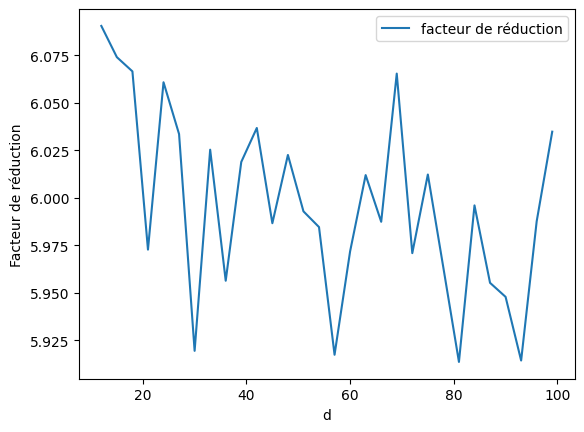

In [38]:
d_range = [i for i in range(12, 100, 3)]
fact_red_list = []
for n in d_range:
    sim_x = monte_carlo_discrete_path(N, n, T, S0, r, sigma)
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    c_star_z2, h_vect, z2_vect = c_opti_z2(sim_x, r, T, K)
    fact_red = 1 / (1 - np.corrcoef(h_vect, z2_vect)[0, 1] ** 2)
    fact_red_list.append(fact_red)

plt.plot(d_range, fact_red_list, label="facteur de réduction")
plt.xlabel("d")
plt.ylabel("Facteur de réduction")
plt.legend()
plt.show()

On retombe bien sur le prix que l'on avait obtenu à la question 2 pour d=12, cependant, avec cette variable de contrôle, le facteur de réduction est deux fois plus grand que celui considéré juste avant. Ceci est lié au fait que les variables aléatoires $Z$ et $h(X)$ sont beaucoup plus corrélées, car l'on retrouve directement l'expression de Z dans la formule du call asiatique.

Cependant, par rapport à la courbe, on remarque que le facteur de réduction semble fluctuer autour d'une valeur moyenne, même avec de grandes valeurs de $d$

Pour le cas où:

$$
Z = e^{-rT} (S_T - K)_+
$$

on reconnait le membre dans l'espérance pour l'évaluation du prix d'un call européen. Ainsi, on a la formule explicite suivante pour l'expression de son espérance:

$$
\mathbb{E}(Z) = S_0 \phi(d_1) - K e^{-rT} \phi(d_2)
$$

On recalcule le $c^*$ pour cette nouvelle variable de contrôle:

In [13]:
def c_opti_z3(sim_x: np.ndarray, r: float, T: float, K: float) -> tuple[float, np.ndarray, np.ndarray]:
    """
    Calculates the optimal c parameter for maximum variance reduction for
    the control variable when Z=exp(-rT) * max(S_T - K, 0)

    **INPUT:**
    - sim_x: Monte-Carlo simulations of the underlying asset
    - r: Risk-free rate
    - T: Maturity of the option
    - K: Strike price of the option

    **OUTPUT:**
    - Optimal c value parameter
    - h_vect: Vector containing the different simulated values for the Asian option prices
    - z3_vect: Control variable simulated values
    """
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    h_mean = h_vect.mean()
    z3_vect = np.exp(-r * T) * np.maximum(sim_x[:, -1] - K, 0)
    z3_mean = z3_vect.mean()
    numerator = np.sum((h_vect - h_mean) * (z3_vect - z3_mean))
    denominator = np.sum(np.square(z3_vect - z3_mean))
    return (- (numerator/denominator), h_vect, z3_vect)

sim_x = monte_carlo_discrete_path(N, d, T, S0, r, sigma)
# Calculating option price
esp_z3 = call_price_black_scholes(K, T, S0, r, sigma)
c_star_z3, h_vect, z3_vect = c_opti_z3(sim_x, r, T, K)
Cc_z3 = np.mean(h_vect + c_star_z3 * (z3_vect - esp_z3))
print(f"Price of the option with the third control variable: {Cc_z3}")

Price of the option with the third control variable: 6.139941045272015


In [14]:
# Calculation of reduction coefficient
fact_red_z3 = 1 / (1 - np.corrcoef(h_vect, z3_vect)[0, 1] ** 2)
print(f"Reduction factor is: {fact_red_z3} for d=12")

Reduction factor is: 3.785307640410611 for d=12


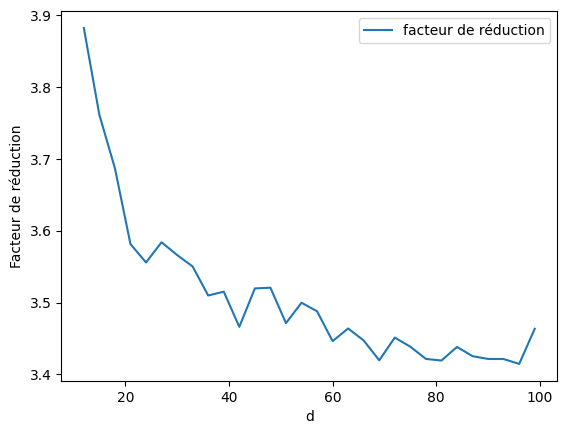

In [29]:
d_range = [i for i in range(12, 100, 3)]
fact_red_list = []
for n in d_range:
    sim_x = monte_carlo_discrete_path(N, n, T, S0, r, sigma)
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    c_star_z3, h_vect, z3_vect = c_opti_z3(sim_x, r, T, K)
    fact_red = 1 / (1 - np.corrcoef(h_vect, z3_vect)[0, 1] ** 2)
    fact_red_list.append(fact_red)

plt.plot(d_range, fact_red_list, label="facteur de réduction")
plt.xlabel("d")
plt.ylabel("Facteur de réduction")
plt.legend()
plt.show()

Ici encore, nous retrouvons bien une valeur cohérente pour l'évaluation de la valeur du call asiatique par rapport aux valeurs trouvées précédemment. Cependant, le facteur de réduction est plus faible que celui considéré précédemment, lié à une plus faible corrélation entre les variables considérées. 

On note également que l'allure de la courbe du facteur de réduction en fonction de $d$ est similaire à celle obtenue dans le cas précédent. le facteur de réduction évolue ainsi de façon semblable en fonction de $d$.

5. Même question avec les trois variables simultanément

On commence par calculer la matrice de covariance du vecteur $Z$ et la covariance entre le vecteur $Z$ et $h(X)$:

In [15]:
def cov_Z(sim_x: np.ndarray, r: float, T: float, K: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Covariance matrix for all three control variables taken
    simultaneously

    **INPUT:**
    - sim_x: Monte-Carlo simulations of the underlying asset
    - r: Risk-free rate
    - T: Maturity of the option
    - K: Strike price of the option

    **OUTPUT:**
    - Covariance matrix of all the three variables
    - z: vector of simulated control variables
    """
    z1 = sim_x[:, -1]
    z2 = sim_x[:, 1:].mean(axis=1)
    z3 = np.exp(-r * T) * np.maximum(sim_x[:, -1] - K, 0)
    z = np.array([z1, z2, z3])
    return np.cov(z), z

def cov_Z_h(sim_x: np.ndarray, r: float, T: float, K: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Vector of covariances between h(X_i) and the different control variables

    **INPUT:**
    - sim_x: Monte-Carlo simulations of the underlying asset
    - r: Risk-free rate
    - T: Maturity of the option
    - K: Strike price of the option

    **OUTPUT:**
    - Covariance vector between h(X_i) and the different control variables
    - h_vect: Simulations of the different values for h(X_i)
    """
    h_vect = np.exp(-r * T) * np.maximum(sim_x[:, 1:].mean(axis=1) - K, 0)
    cov_h_z1 = np.cov(h_vect, sim_x[:, -1])[0, 1]
    cov_h_z2 = np.cov(h_vect, sim_x[:, 1:].mean(axis=1))[0, 1]
    cov_h_z3 = np.cov(h_vect, np.exp(-r * T) * np.maximum(sim_x[:, -1] - K, 0))[0, 1]
    return np.array([[cov_h_z1], [cov_h_z2], [cov_h_z3]]), h_vect

sim_x = monte_carlo_discrete_path(N, d, T, S0, r, sigma)
cov_z, z = cov_Z(sim_x, r, T, K)
cov_z_h, h_vect = cov_Z_h(sim_x, r, T, K)


On peut ainsi calculer le $c^*$ pour notre vecteur de variables de contrôles par la formule:

$$
c^* = -(\Sigma_Z)^{-1} \Sigma_{Z, h(X)}
$$

On en déduit le prix de notre option par la suite:

In [25]:

c_star = np.linalg.solve(cov_z, -cov_z_h)
esp_z = np.array([
    [np.exp(r * T)* S0],
    [(S0 / d) * np.exp((r * T) / d) * ((1 - np.exp(r * T)) / (1 - np.exp((r * T)/d)))],
    [call_price_black_scholes(K, T, S0, r, sigma)]
])

Cc = np.mean(h_vect + c_star * (z - esp_z) )
print(f"Price of the option with the combined control variables: {Cc}")

Price of the option with the combined control variables: 6.129202565152464


Encore une fois, nous retombons bien sur une valeur pour le pricing du call asiatique attendue.

In [ ]:
# Reduction coefficient calculation
corr = (np.dot(cov_z_h.T, np.dot(np.linalg.inv(cov_z), cov_z_h)) / h_vect.var())[0][0]
fact_red = 1 / (1 - corr**2)
print(f"Reduction factor is: {fact_red.round(2)} for d=12")

Reduction factor is: 7.01 for d=12


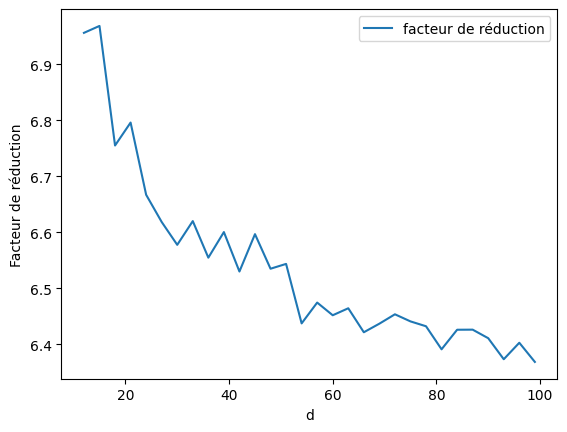

In [30]:
d_range = [i for i in range(12, 100, 3)]
fact_red_list = []
for n in d_range:
    sim_x = monte_carlo_discrete_path(N, n, T, S0, r, sigma)
    cov_z, z = cov_Z(sim_x, r, T, K)
    cov_z_h, h_vect = cov_Z_h(sim_x, r, T, K)
    corr = (np.dot(cov_z_h.T, np.dot(np.linalg.inv(cov_z), cov_z_h)) / h_vect.var())[0][0]
    fact_red = 1 / (1 - corr ** 2)
    fact_red_list.append(fact_red)

plt.plot(d_range, fact_red_list, label="facteur de réduction")
plt.xlabel("d")
plt.ylabel("Facteur de réduction")
plt.legend()
plt.show()

Le facteur de réduction est meilleur que l'ensemble de ceux obtenus auparavant, ce qui valide l'utilisation de cette méthode dans ce cas. Même pour de grandes valeurs de $d$ on reste avec un facteur de réduction bien meilleur que ceux obtenus aux question précédentes. 

6. (*Pour aller plus loin*) Reprendre la question 2 pour une option asiatique à moyenne géométrique et vérifier la convergence vers la valeur exacte.

Afin d'évaluer le prix d'un call asiatique avec moyenne géométrique, nous disposons de la formule exacte suivante:

$$
C = e^{-rT} (S_0 e^{\mu_n T} \mathcal{N}(d_n) - K \mathcal{N}(d_n - \sigma_n \sqrt{T}))
$$

avec:

$$
\sigma_n^2 = \frac{\sigma^2 (n+1) (2n + 1)}{6 n^2},
\mu_n = (r - \frac{\sigma^2}{2})\frac{n + 1}{2n} + \frac{\sigma_n^2}{2}
$$

et 

$$
d_n = \frac{\ln(\frac{S_0}{K}) + (\mu_n + \frac{\sigma_n^2}{2})T}{\sigma_n \sqrt(T)}
$$

Nous pouvons ainsi programmer la fonction qui permet de calculer directement ce prix:

In [ ]:
def exact_asian_geo_call(S0: float, K: float, T: float, r: float, sigma: float, n: float) -> float:
    """
    Returns the exact asian geometric call price in the Black & Scholes model

    **INPUT:**
    - S0: price of the underlying asset S at time 0
    - K: strike of the option
    - T: maturity of the option
    - r: risk-free rate
    - sigma: volatility
    - n: number of periods to consider

    **OUTPUT:**
    - c_exact_price: exact price of the asian geometric option
    """
    sigma_n = np.sqrt((sigma ** 2) * (n + 1) * (2 * n + 1) / (6 * (n ** 2)))
    mu_n = (r - 0.5 * (sigma ** 2)) * (n + 1) / (2 * n) + 0.5 * (sigma_n ** 2)
    d_n = (np.log(S0 / K) + (mu_n + 0.5 * (sigma_n ** 2)) * T) / (sigma_n * np.sqrt(T))
    c_exact_price = np.exp(- r * T) * (S0 * np.exp(mu_n * T) * norm.cdf(d_n) - K * norm.cdf(d_n - sigma_n * np.sqrt(T)))  
    return c_exact_price

Nous écrivons ensuite la fonction qui permet de faire une approximation de ce prix avec la méthode de Monte-Carlo:

In [19]:
def MC_asian_geo_option(K: float, T: float, S0: float, r: float, sigma: float, n: int, N: int, alpha: float = 0.05) -> tuple[float, np.ndarray]:
    """
    Works out the estimated Monte Carlo asian geometric call price in 
    the Black & Scholes model:

    **INPUT:**
    - K: strike of the option
    - T: maturity of the option
    - S0: price of the underlying asset S at time 0
    - r: risk-free rate
    - sigma: volatility
    - n: number of periods to consider
    - N: number of simulations to perform for Monte Carlo
    - alpha: confidence interval level

    **OUTPUT:**
    - Estimated Monte Carlo price for the option
    - Confidence interval associated
    """
    sim_x = monte_carlo_discrete_path(N=N, d=n, T=T, S0=S0, r=r, sigma=sigma)
    payoffs = np.maximum(np.exp(np.log(sim_x[:, 1:]).mean(axis=1)) - K, 0)
    Cn = np.mean(np.exp(-r * T) * payoffs)
    return Cn, Cn + np.array(norm.interval(1 - alpha)) * np.exp(-r * T) * standard_error(payoffs)

On a donc les valeurs suivantes exacte vs estimée:

In [20]:
# Exact value
C_exact = exact_asian_geo_call(S0, K, T, r, sigma, n)
print(f"Black & Scholes exact price for the option: {C_exact}")

# Monte Carlo value
C_mc = MC_asian_geo_option(K, T, S0, r, sigma, n, N)[0]
print(f"Monte-Carlo estimated price for the option: {C_mc}")

Black & Scholes exact price for the option: 5.594401516408829
Monte-Carlo estimated price for the option: 5.5619124315103745


Nous voyons que notre implémentation de Monte-Carlo converge bien vers le prix exact pour l'option asiatique géométrique discrète.

On peut tracer l'effet du paramètre $d$ sur ce prix:

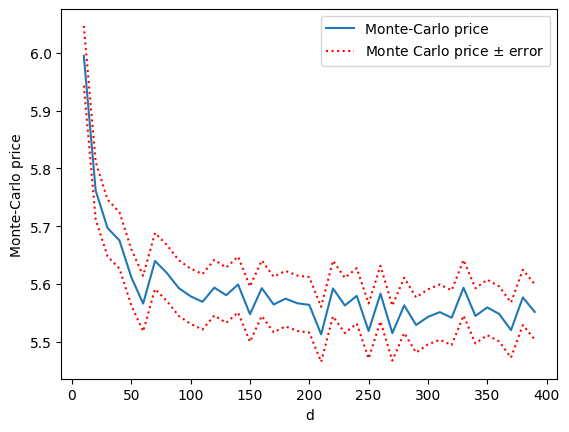

In [21]:
Cns, Cns_up, Cns_down = [], [], []
d_range = [i for i in range(10, 400, 10)]
for n in d_range:
    Cn, error_Cn = MC_asian_geo_option(K, T, S0, r, sigma, n, N)
    Cns.append(Cn)
    Cns_up.append(error_Cn[1])
    Cns_down.append(error_Cn[0])
plt.plot(d_range, Cns, label="Monte-Carlo price")
plt.plot(d_range, Cns_up, linestyle=":", color="red", label="Monte Carlo price $\pm$ error")
plt.plot(d_range, Cns_down, linestyle=":", color="red")
plt.xlabel("d")
plt.ylabel("Monte-Carlo price")
plt.legend()
plt.show()

Le nombre d'observations n'a toujours pas d'influence sur l'intervalle de confiance et donc la réduction de l'incertitude.